In [6]:
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from utils import *
from matplotlib import pyplot as plt

In [7]:
"""
离散型、连续型特征分类
"""
columnToken_common = ['性别', '省', '民族', '宗教信仰', '学历', '体型']
columnToken_nurse = ['常驻医院', '主要负责病区', '其他负责病区']
columnToken_patient = ['过敏史', '是否残疾', '暴露史', '是否吸烟', '是否饮酒', '常饮酒类', '所属医院', '所在病区']

columnNumber_common = ['年龄', '身高', '体重', 'BMI指数']
columnNumber_nurse = ['普通话程度', '方言程度', '在岗时间', '擅长科室种类', '接单数', '活跃度', '评分']
columnNumber_patient = ['烟龄', '平均每日吸烟次数', '平均每日饮酒次数', '锻炼频率', '刷牙频率', '重症等级']

nurseColumns = columnNumber_common + columnNumber_nurse + columnToken_common + columnToken_nurse
patientColumns = columnNumber_common + columnNumber_patient + columnToken_common + columnToken_patient

GCN_config_nurse = {
    'input_features': len(nurseColumns) * 8,
    'hidden_features': 16,
    'out_features': 8,
    'dropout': 0.5
}
GCN_config_patient = {
    'input_features': len(patientColumns) * 8,
    'hidden_features': 16,
    'out_features': 8,
    'dropout': 0.5
}

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nurseData = pd.read_csv('../../data/nurseData_200.csv')
patientData = pd.read_csv('../../data/patientData_1000.csv')

nurseData_token = getData(nurseData, columnToken_common + columnToken_nurse, True, device)
nurseData_number = getData(nurseData, columnNumber_common + columnNumber_nurse, False, device)
patientData_token = getData(patientData, columnToken_common + columnToken_patient, True, device)
patientData_number = getData(patientData, columnNumber_common + columnNumber_patient, False, device)

tokenCount = getVocabulary('../../data/token2Id.txt')

indexData_train, scoreData_train = getLabels('../../data/train/trainLabels_200_1000_90.txt', device)
indexData_val, scoreData_val = getLabels('../../data/val/valLabels_200_1000_10.txt', device)

In [9]:
adjDatas = []

k = 0.9
while k >= 0.5:
    adjData_nurse = getAdj(f'../../data/edge/200_1000/edge_nurse_{round(k, 1)}_dist.txt', nurseData.shape[0], device)
    adjData_patient = getAdj(f'../../data/edge/200_1000/edge_patient_{round(k, 1)}_dist.txt', patientData.shape[0], device)

    adjDatas.append((adjData_nurse, adjData_patient))
    k -= 0.1

In [10]:
losses_val = []
epochs, step, MAX_PATIENCE_CNT = 10000, 200, 1000
for i in range(len(adjDatas)):
    setSeed(2024)
    onlyGCN = getModelConfig(n_count_nurse=nurseData_number.shape[1], n_count_patient=patientData_number.shape[1],
                             t_count=tokenCount, embedded_size=8,
                             useHAT=False, hat_config_nurse=None, hat_config_patient=None,
                             useGAT=False, gat_config_nurse=None, gat_config_patient=None,
                             useGCN=True, gcn_config_nurse=GCN_config_nurse, gcn_config_patient=GCN_config_patient)
    model = getModel(onlyGCN[0], onlyGCN[1], isOnlyHAT=False).to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-4)
    criterion = nn.L1Loss()

    BEST_VAL_LOSS, PATIENCE_CNT = 5, 0
    lossValues_val = []
    for epoch in range(1, epochs + 1):
        model.train()
        outputs_train = model((nurseData_number, nurseData_token, adjDatas[i][0]),
                              (patientData_number, patientData_token, adjDatas[i][1]), indexData_train)
        loss_train = criterion(outputs_train, scoreData_train.view(-1, 1))
        lossValue_train = loss_train.item()

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            outputs_val = model((nurseData_number, nurseData_token, adjDatas[i][0]),
                                    (patientData_number, patientData_token, adjDatas[i][1]), indexData_val)
            loss_val = criterion(outputs_val, scoreData_val.view(-1, 1))
            lossValue_val = loss_val.item()

            if lossValue_val < BEST_VAL_LOSS:
                BEST_VAL_LOSS = lossValue_val
                PATIENCE_CNT = 0
            else:
                PATIENCE_CNT += 1

            lossValues_val.append(lossValue_val)
            if epoch % step == 0:
                print(
                    f'Epoch {epoch}/{epochs}, '
                    f'Train Loss: {lossValue_train:.4f}, '
                    f'Val Loss: {lossValue_val:.4f}, '
                    f'Best Val Loss: {BEST_VAL_LOSS}')

            if PATIENCE_CNT >= MAX_PATIENCE_CNT:
                break

    losses_val.append(lossValues_val)
    print()

Epoch 200/10000, Train Loss: 0.1487, Val Loss: 0.1411, Best Val Loss: 0.14045406877994537
Epoch 400/10000, Train Loss: 0.1292, Val Loss: 0.1173, Best Val Loss: 0.11729880422353745
Epoch 600/10000, Train Loss: 0.1225, Val Loss: 0.1097, Best Val Loss: 0.10894940793514252
Epoch 800/10000, Train Loss: 0.1210, Val Loss: 0.1085, Best Val Loss: 0.10792230814695358
Epoch 1000/10000, Train Loss: 0.1198, Val Loss: 0.1077, Best Val Loss: 0.10689669102430344
Epoch 1200/10000, Train Loss: 0.1199, Val Loss: 0.1054, Best Val Loss: 0.10517092049121857
Epoch 1400/10000, Train Loss: 0.1180, Val Loss: 0.1045, Best Val Loss: 0.10409563779830933
Epoch 1600/10000, Train Loss: 0.1156, Val Loss: 0.1043, Best Val Loss: 0.10259969532489777
Epoch 1800/10000, Train Loss: 0.1135, Val Loss: 0.1032, Best Val Loss: 0.10172279924154282
Epoch 2000/10000, Train Loss: 0.1139, Val Loss: 0.1024, Best Val Loss: 0.10142190754413605
Epoch 2200/10000, Train Loss: 0.1133, Val Loss: 0.1017, Best Val Loss: 0.1008923128247261
Epoc

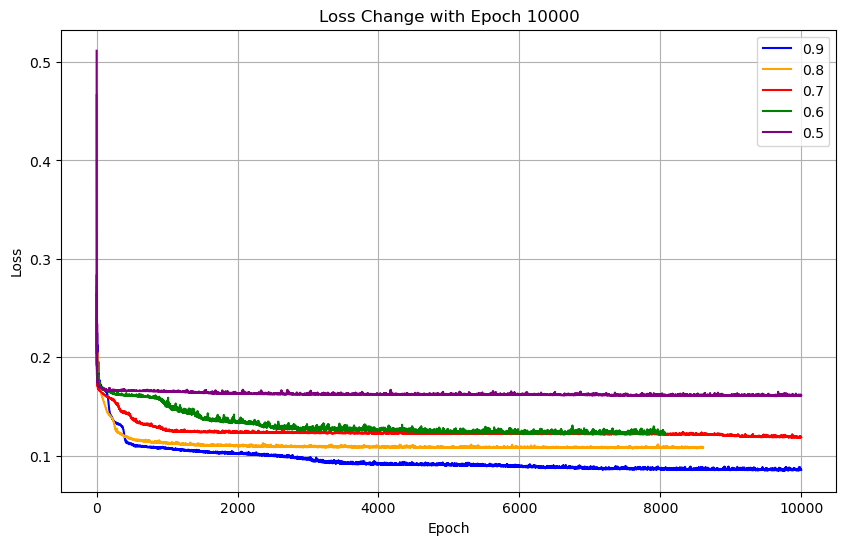

In [16]:
# 创建折线图
fig = plt.figure(figsize=(10, 6))  # 设置图形大小

colors = ['blue', 'orange', 'red', 'green', 'purple']
labels = ['0.9', '0.8', '0.7', '0.6', '0.5']
for i in range(len(adjDatas)):
    plt.plot(losses_val[i], color=colors[i], linestyle='-', label=labels[i])

plt.title('Loss Change with Epoch 10000')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.savefig('k_lab_useGCN.png')
plt.show()